<a href="https://colab.research.google.com/github/Muhammad-Ahtasham/Fashion-Gan/blob/master/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Dependencies**

In [ ]:
# !pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
# !pip install tensorflow-gpu

## Importing libraries

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
ds.as_numpy_iterator().next()['label']

2

# Visualization

In [ ]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

In [ ]:
# dataiterator.next()

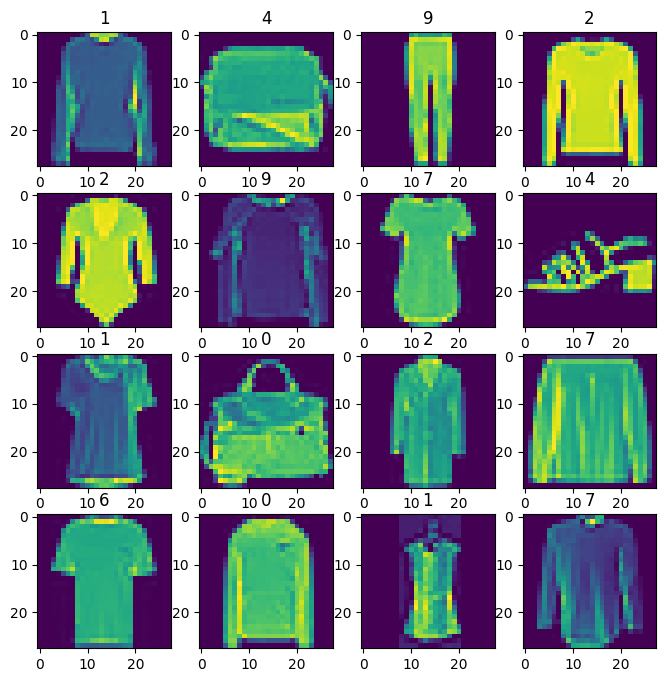

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(8,8))
index = 0
for x in range(4):
  for y in range(4):
    ax[x,y].imshow(dataiterator.next()['image'])
    ax[x,y].title.set_text(dataiterator.next()['label'])

In [ ]:
def scale_image(data):
  image = data['image']
  return image/255

In [ ]:
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, 4, activation='sigmoid', padding='same'))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [ ]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 96ms/step


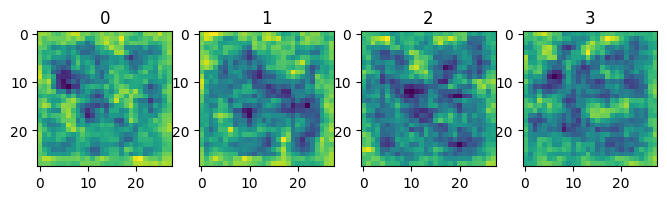

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(8,8))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [ ]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 143ms/step


array([[0.5039324]], dtype=float32)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake = tf.concat([noise_real, noise_fake], axis=0)

      #calculate the loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
      predicted_labels = self.discriminator(gen_images, training=False)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {'d_loss': total_d_loss, 'g_loss': total_g_loss}



In [ ]:
fashgan = FashionGAN(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
import os
from keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class GANMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      # img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
      img.save(os.path.join(f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = fashgan.fit(ds, epochs=50, callbacks=[GANMonitor()]) #2000 recommended

Epoch 1/50
  6/469 [..............................] - ETA: 1:11 - d_loss: -0.4161 - g_loss: 2.4454e-09

469/469 [==============================] - 74s 158ms/step - d_loss: -0.4433 - g_loss: 2.3522e-09
Epoch 2/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4428 - g_loss: 1.8690e-09
Epoch 3/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4423 - g_loss: 1.4216e-09
Epoch 4/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4445 - g_loss: 1.1318e-09
Epoch 5/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4463 - g_loss: 1.0334e-09
Epoch 6/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4451 - g_loss: 8.0867e-10
Epoch 7/50
469/469 [==============================] - 74s 158ms/step - d_loss: -0.4447 - g_loss: 7.4118e-10
Epoch 8/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4442 - g_loss: 7.5261e-10
Epoch 9/50
469/469 [==============================] - 74s 157ms/step - d_loss: -0.4453 - g_loss: 6.8496e-10
Epoch 10/50
469/469 [==================

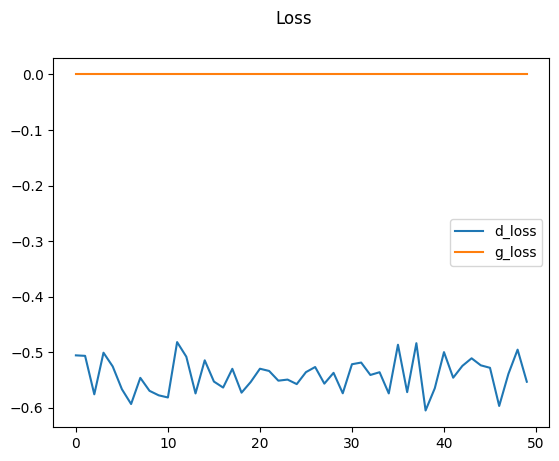

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
# generator.load_weights(os.path.join('archive', 'generatormodel.h5'))
generator.load_weights('generatormodel.h5')

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 18ms/step


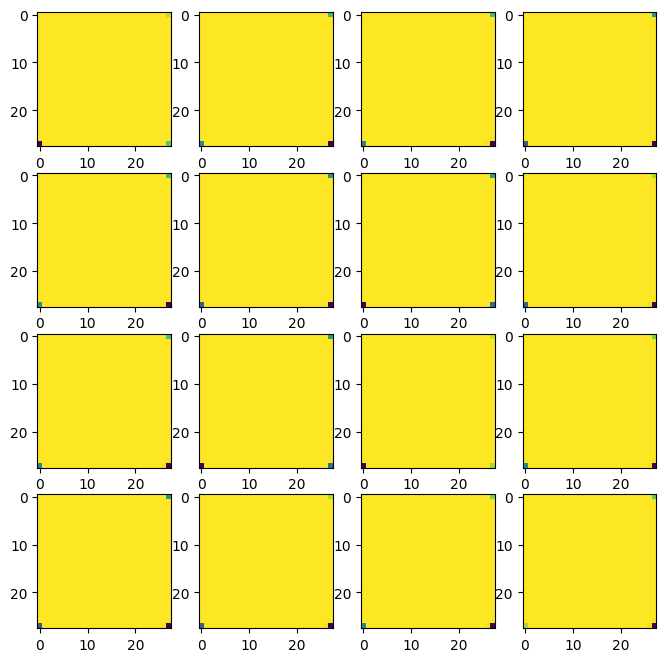

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(8,8))
for r in range(4):
  for c in range(4):
    ax[r,c].imshow(imgs[(r+1)*(c+1)-1])
plt.show()

In [ ]:
generator.save('generatormodel.h5')
discriminator.save('discriminatormodel.h5')